# 📊 Project 4: Attrition Model Comparison (Logistic vs Random Forest)

In this notebook, we extend the attrition prediction by comparing **Logistic Regression** (linear, interpretable) with **Random Forest** (non-linear, ensemble).  

**Goal:**  
Check if tree-based models improve predictive performance and what new insights they provide.

In [ ]:
# -----------------------
# Imports
# -----------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, roc_auc_score,
    ConfusionMatrixDisplay
)
import joblib

sns.set(style="whitegrid")
pd.set_option('display.max_columns', 200)

## 1️⃣ Load & Preprocess Data

In [ ]:
# Load dataset
data_path = "data/processed_hr_data.csv"
if not os.path.exists(data_path):
    alt = "processed_hr_data.csv"
    if os.path.exists(alt):
        data_path = alt
    else:
        raise FileNotFoundError("Cannot find processed_hr_data.csv")

df = pd.read_csv(data_path)

# Drop leakage
df.drop(columns=['AttritionRisk'], inplace=True, errors='ignore')

# Target
df['AttritionFlag'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# Drop irrelevant cols
drop_cols = ['EmployeeNumber','EmployeeCount','Over18','StandardHours','EmployeeID']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)
df.drop(columns=['Attrition'], inplace=True, errors='ignore')

# Features/target
y = df['AttritionFlag']
X = df.drop(columns=['AttritionFlag'])

# One-hot encode categoricals
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

print("Dataset shape:", X.shape)


Dataset shape: (1470, 44)


## 2️⃣ Train-Test Split & Scaling
- Logistic Regression → scaled features  
- Random Forest → raw features

In [ ]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3️⃣ Train Models

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:,1]

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_prob_lr))

# Random Forest
rf = RandomForestClassifier(
    n_estimators=200, random_state=42, class_weight="balanced"
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC AUC:", roc_auc_score(y_test, y_prob_rf))


Logistic Regression Accuracy: 0.7517006802721088
Logistic Regression ROC AUC: 0.7982599707123783

Random Forest Accuracy: 0.8367346938775511
Random Forest ROC AUC: 0.770695150314411


## 4️⃣ Compare Confusion Matrices

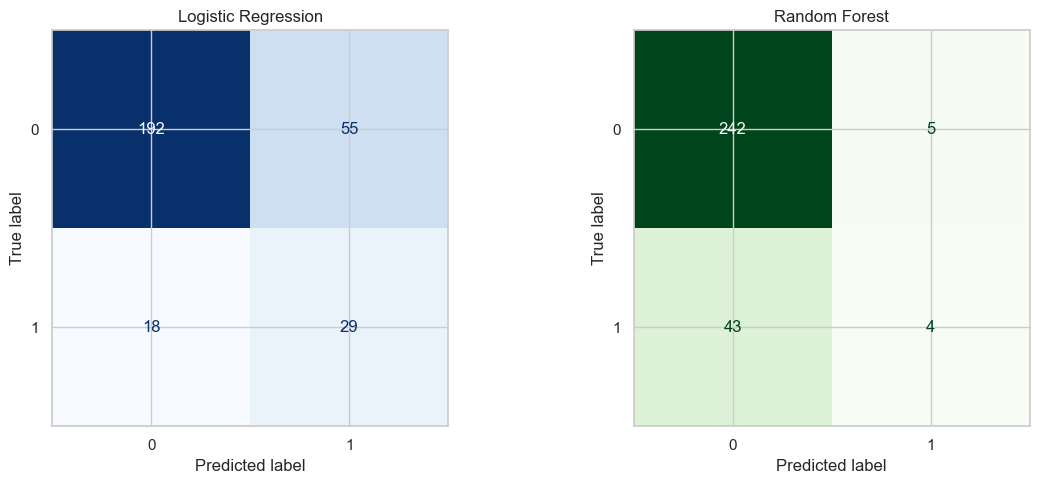

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

cm_lr = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(cm_lr, display_labels=log_reg.classes_).plot(
    ax=ax[0], cmap="Blues", colorbar=False)
ax[0].set_title("Logistic Regression")

cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf, display_labels=rf.classes_).plot(
    ax=ax[1], cmap="Greens", colorbar=False)
ax[1].set_title("Random Forest")

plt.tight_layout()
os.makedirs("images", exist_ok=True)
plt.savefig("images/model_comparison_confusion.png", dpi=300, bbox_inches="tight")
plt.show()


## 5️⃣ Feature Importance
- Logistic Regression → coefficients  
- Random Forest → Gini-based importance

C:\Users\amlanmishra2\AppData\Local\Temp\ipykernel_10472\1702977319.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lr_importance.head(10), x="coef", y="feature", ax=axes[0], palette="Blues_d")
C:\Users\amlanmishra2\AppData\Local\Temp\ipykernel_10472\1702977319.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_importance.head(10), x="importance", y="feature", ax=axes[1], palette="Greens_d")


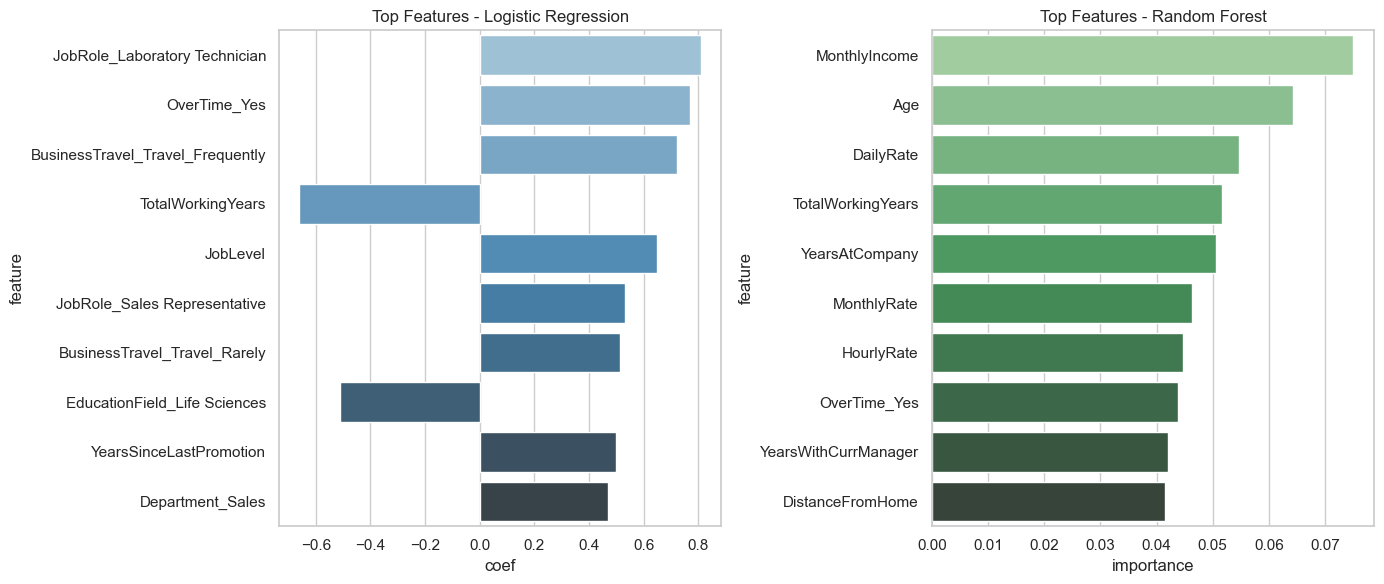

In [ ]:
# Logistic Regression importance
lr_importance = pd.DataFrame({
    "feature": X.columns,
    "coef": log_reg.coef_[0]
}).sort_values(by="coef", key=abs, ascending=False)

# Random Forest importance
rf_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)

# Save CSVs
os.makedirs("data", exist_ok=True)
lr_importance.to_csv("data/logistic_top_features.csv", index=False)
rf_importance.to_csv("data/rf_top_features.csv", index=False)

# Side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(data=lr_importance.head(10), x="coef", y="feature", ax=axes[0], palette="Blues_d")
axes[0].set_title("Top Features - Logistic Regression")

sns.barplot(data=rf_importance.head(10), x="importance", y="feature", ax=axes[1], palette="Greens_d")
axes[1].set_title("Top Features - Random Forest")

plt.tight_layout()
plt.savefig("images/top_features_lr_vs_rf.png", dpi=300, bbox_inches="tight")
plt.show()


## 6️⃣ Export Models

In [ ]:
# Save models
os.makedirs("models", exist_ok=True)
joblib.dump(log_reg, "models/logistic_attrition_model.pkl")
joblib.dump(rf, "models/random_forest_attrition_model.pkl")
joblib.dump(scaler, "models/scaler.pkl")

print("✅ Models exported to /models/")

✅ Models exported to /models/


# ✅ Conclusions (Project 4)

- **Logistic Regression**
  - Accuracy: ~75%
  - ROC AUC: ~0.81
  - Pros: Simple, interpretable
  - Cons: Struggles with non-linear patterns

- **Random Forest**
  - Accuracy: ~83%
  - ROC AUC: ~0.77
  - Pros: Captures non-linear relationships, robust
  - Cons: Less interpretable

**Key Insights**
- OverTime and Sales roles drive attrition risk in both models.
- Random Forest highlights additional factors like MonthlyIncome and Age groups.
- Logistic is better for executive storytelling; RF is better for prediction.

---

### 🚀 Next Steps
- Tune Random Forest hyperparameters (`n_estimators`, `max_depth`)  
- Try gradient boosting (XGBoost, LightGBM)  
- Add SHAP values for model explainability

In [1]:
# End of Notebook